# topic2linkedin_post.ai
### Automatically Generate, Optimize & Post LinkedIn Content from Just a Topic

> One topic in → AI-written post + relevant image out → Shared on LinkedIn 


<h1 style = "color:Orange";>topic2linked_post.ai</h1>

In [387]:
from langgraph.graph import StateGraph , END , START , message
from typing import Annotated , TypedDict , Literal
from pydantic import BaseModel , Field
from langchain_together import ChatTogether
import operator
from langchain_core.messages import HumanMessage , SystemMessage , AIMessage
from dotenv import load_dotenv
import praw
import requests
import os
from together import Together
import json

In [388]:
class GeneratePost(BaseModel):
    title : str = Field(... , description="the suitable title for the post")
    post : str

In [389]:
class EvaluatePost(BaseModel):
    status : Literal["approve" , "need_improvement"] = Field(... , description="the final evaluation should be approve or need_improvement")
    feedback : str = Field(... , description="feedback for the tweet ")

In [390]:
model = ChatTogether(model= "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free")
generator_model = model.with_structured_output(GeneratePost)
evaluator_model = model.with_structured_output(EvaluatePost)
optimizer_model = ChatTogether(model= "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free")


In [391]:
class PostState(TypedDict):
    topic :str
    post : str
    evaluate : str
    optimize : str
    title:str
    feedback : str
    status: Literal["approve" ,"need_improvement"]
    response:str
    status_code:int
    uploadurl:str
    uploadassets:str
    image_path:str
    generate_image:Literal[True , False]
    next:str
    path_choose:str
    
    url:str
    score:int
    iteration: int
    max_iteration:int
    post_history : Annotated[str , operator.add]

In [392]:
import os
os.environ["TOGETHER_API_KEY"] = "tgp_v1_W1SCWfDm-ILpFfLGsoq5rfatMHS7TsdQTK_TTjBGRSc"

In [393]:

image_model = Together(api_key= "tgp_v1_W1SCWfDm-ILpFfLGsoq5rfatMHS7TsdQTK_TTjBGRSc")

In [394]:
output = image_model.images.generate(
    prompt= "hello",
    model="black-forest-labs/FLUX.1-schnell-Free",
    steps=4,
    n=4
    )

In [395]:
output

ImageResponse(id='o4EjhWs-2kFHot-963c31e0cd994448-PDX', model='black-forest-labs/FLUX.1-schnell-Free', object='list', data=[ImageChoicesData(index=0, b64_json=None, url='https://api.together.ai/shrt/NsXKK6WVVfd80HlY', timings={'inference': 1.2468731417320669})])

In [396]:
def generate_post(state:PostState) -> dict:

    prompt = [
    SystemMessage(content=(
        "You are a thoughtful and engaging LinkedIn content strategist. "
        "You write posts that spark conversations, demonstrate thought leadership, "
        "and resonate emotionally with a professional audience."
    )),

    HumanMessage(content=(
        f"""
You're given a topic: "{state['topic']}".

Based on this, write a **LinkedIn post** that is:
- Insightful, emotionally resonant, or thought-provoking  
- Rooted in a personal experience, lesson, or surprising fact  
- Authentic and human—not corporate or robotic  
- Written in a first-person or conversational tone  
- Structured for readability with short paragraphs, line breaks, and/or emojis (optional)  
- Capable of generating engagement (comments, shares, or saves)  

---

**Rules for the post**:
- Word count: 150–300 words (sweet spot for LinkedIn)  
- Must include at least one practical insight, professional lesson, or industry stat/fact  
- Hook readers in the **first 2 lines** (important for 'See More' clicks)  
- Conclude with a question or call-to-engagement (e.g., "What are your thoughts?")  
- Avoid jargon, buzzwords, or generic corporate phrases  
- Authentic storytelling beats polished perfection  

Optional:
- Include 2–4 relevant hashtags at the end  
- Emojis are fine, but use them sparingly and tastefully  

Write the post below:
        """
    ))
]


    
    response = generator_model.invoke(prompt)
    title = response.title
    post = response.post
    return {'post' : post , "title":title , "post_history":post}

In [397]:
def evaluate_post(state:PostState):
    prompt = [
    SystemMessage(content=(
        "You are an experienced social media strategist for LinkedIn. "
        "You evaluate posts based on their ability to inform, engage, and connect with a professional audience."
    )),

    HumanMessage(content=(
        f"""
You will be given a LinkedIn post and its topic.

Evaluate the post using these **key performance rules**:

1. Starts with a strong **hook in the first 1–2 lines**  
2. Includes a clear **personal experience, insight, or industry perspective**  
3. Shares **one real, credible fact or takeaway**  
4. Uses **clear and engaging language** (not too formal, not robotic)  
5. Follows **LinkedIn post structure**: short paragraphs, clean formatting  
6. Ends with **a relatable reflection or a call-to-engagement**  
7. Word count is **between 150–300 words**  
8. Avoids fluff, cliches, or overly promotional language  

---

**Response format**:
- If the post meets all the criteria, respond with: `approve`  
- If anything is missing, respond with: `improvement_required`, followed by 1–2 clear suggestions on what needs to be improved and why  

---

**Topic**: "{state['topic']}"  
**Post**:
\"""{state['post']}\"""
        """
    ))
]

    response = evaluator_model.invoke(prompt)
    status = response.status
    feedback = response.feedback

    return {"status":status , "feedback":feedback , "evaluate":response}
    

In [398]:
def optimize_post(state:PostState):
    prompt = [
    SystemMessage(content="You are a top-performing LinkedIn ghostwriter. You rewrite and enhance posts to maximize professional impact, engagement, and relatability."),

    HumanMessage(content=f"""
You’re given:

1. An original LinkedIn post
2. Feedback on what needs to improve

Your task is to **rewrite the post** so it:
- Hooks readers within the **first two lines**
- Shares a clear **story, insight, or challenge**
- Includes **one real, helpful takeaway or industry fact**
- Ends with **a call-to-conversation** (e.g., a question or reflection)
- Uses a **casual, yet professional tone**
- Is formatted for readability on mobile (line breaks, short paras)
- Stays under **300 words**
- Avoids buzzwords and clichés (e.g., "synergy", "disruption")
- Sounds human, not AI-generated or overly polished
- Optional: includes 2–4 relevant hashtags and **1–2 emojis max**

---

**Original Post**:
\"""{state['post']}\"""

**Evaluator Feedback**:
\"""{state['feedback']}\"""

---

**Improved Post**:
""")
]

    response = optimizer_model.invoke(prompt).content
    return {'post':response , "post_history":response}

In [399]:
def decision_one(state:PostState):
    if state['status'] == "approve" or state['iteration'] >= state['max_iteration']:
        return "approve"

    elif state['status'] == "need_improvement":
        return "need_improvement"

In [400]:
def decision_two(state: PostState):
    if state.get('image_path') is not None:
        print("image_path found, media_post_on_linkedin")
        return "media_post_on_linkedin"
    
    elif not state.get('generate_image', False):
        print("generate_image is False or missing, post_on_linkedin")
        return "post_on_linkedin"
    
    elif state.get("generate_image") is True:
        print("generate_image is True, generate_ai_image")
        return "generate_ai_image"


In [401]:
def generate_ai_image(state: PostState):
    
    image_model = Together(api_key= "tgp_v1_W1SCWfDm-ILpFfLGsoq5rfatMHS7TsdQTK_TTjBGRSc")
    topic = state['topic']
    output = image_model.images.generate(
        prompt=topic,
        model="black-forest-labs/FLUX.1-schnell-Free",
        steps=4,
        n=1
    )
    img_url = output.data[0].url
    response = requests.get(img_url)
    image_path = "generated_image.png"
    with open(image_path, 'wb') as f:
        f.write(response.content)

    return {"image_path": image_path}

In [402]:
def post_on_linkedin(state):
    load_dotenv()
    headers = {
        "Authorization": f"Bearer {os.getenv('Linkedin')}",
        "X-Restli-Protocol-Version": "2.0.0",
        "Content-Type": "application/json"
    }

    data = {
        "author": "urn:li:person:WVAL9qk4uX",
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": {
                    "text": state["post"]
                },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    response = requests.post("https://api.linkedin.com/v2/ugcPosts", headers=headers, json=data)

    return {
        "status_code": response.status_code,
        "response": response.json()
    }


In [403]:
def media_post_on_linkedin(state:PostState):
    ugc_url = "https://api.linkedin.com/v2/ugcPosts"
    urn_id = "urn:li:person:WVAL9qk4uX"
    access_token = os.getenv('Linkedin')
    registration_url = "https://api.linkedin.com/v2/assets?action=registerUpload"


    headers = {
        "Authorization": f"Bearer {access_token}",
        "X-Restli-Protocol-Version": "2.0.0",
        "Content-Type": "application/json"
    }

    registration_body = {
    "registerUploadRequest": {
        "recipes": [
            "urn:li:digitalmediaRecipe:feedshare-image"
        ],
        "owner": urn_id,
        "serviceRelationships": [
            {
                "relationshipType": "OWNER",
                "identifier": "urn:li:userGeneratedContent"
            }
        ]
    }
    }

    response1 = requests.post(registration_url , headers=headers , json=registration_body)

    if response1.status_code not in [200 , 201]:
        raise Exception(f"image registration faiuled {response1.status_code} \n Error :- \n {response1.text}")
    
    data = response1.json()
    state['uploadurl'] = data['value']['uploadMechanism']['com.linkedin.digitalmedia.uploading.MediaUploadHttpRequest']['uploadUrl']
    state['uploadassets'] = data['value']['asset']

    with open(f"{state['image_path']}" , 'rb') as image_file:
        upload_image = requests.post(
            state['uploadurl'] , 
            headers= {"Authorization": f"Bearer {access_token}"},
            data= image_file
        )

    if upload_image.status_code not in [200,201]:
        Exception(f"Failed to upload image on linkedin media server  \n {upload_image.text}")


    post_body = {
    "author": urn_id,
    "lifecycleState": "PUBLISHED",
    "specificContent": {
        "com.linkedin.ugc.ShareContent": {
            "shareCommentary": {
                "text": state['post']
            },
            "shareMediaCategory": "IMAGE",
            "media": [
                {
                    "status": "READY",
                    "description": {
                        "text": "Center stage!"
                    },
                    "media": state['uploadassets'],
                    "title": {
                        "text": "Posting Via ai agents on Linkedin"
                    }
                }
            ]
        }
    },
    "visibility": {
        "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
    }
    }



    response2 = requests.post(ugc_url , headers=headers  , json= post_body)

    if response2.status_code not in [ 200 , 201]:
        Exception(f"Failed to post the image on Linkedin \n {response2.status_code} \n {response2.text}")

    print("Successfully Post the image on Linkedin")

In [404]:
def post_decision(state:PostState):
    return state

In [405]:
graph = StateGraph(PostState)

graph.add_node("generate_post" , generate_post)
graph.add_node("evaluate_post" , evaluate_post)
graph.add_node("optimize_post" , optimize_post)
graph.add_node("post_on_linkedin" , post_on_linkedin)
graph.add_node("media_post_on_linkedin" , media_post_on_linkedin)
graph.add_node("post_decision" , post_decision)
graph.add_node("generate_ai_image" , generate_ai_image)

graph.add_edge(START , "generate_post")
graph.add_edge("generate_post" , "evaluate_post")
graph.add_conditional_edges("evaluate_post" , decision_one , {"approve":"post_decision" , "need_improvement": "optimize_post"})
graph.add_edge("optimize_post" , "evaluate_post")
graph.add_conditional_edges("post_decision" , decision_two , {"media_post_on_linkedin": "media_post_on_linkedin" , "post_on_linkedin":"post_on_linkedin" , "generate_ai_image" : "generate_ai_image" })
graph.add_edge("generate_ai_image" , "media_post_on_linkedin")
graph.add_edge("post_on_linkedin" , END)
graph.add_edge("media_post_on_linkedin" , END)

workflow = graph.compile()

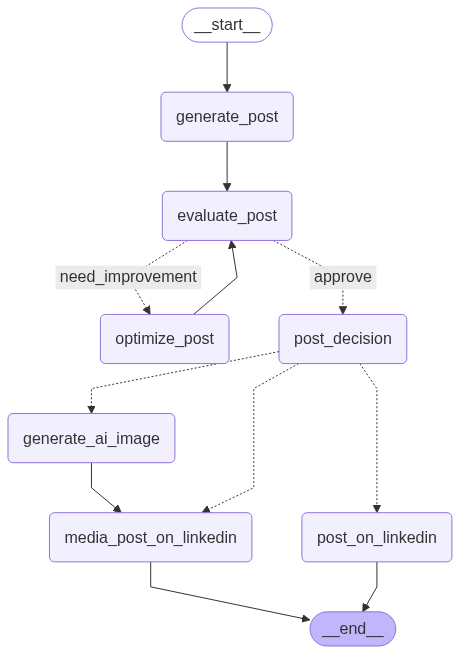

In [406]:
workflow

In [410]:
initial_state = {
    "topic": "ai agent that ca n generate , evaluate , and optimize the linkedin post , and also add in starting of the post that this is wirtten and uploaded by an ai agent",
    "iteration": 1,
    "max_iteration": 5,
    "generate_image": True,
}

output = workflow.invoke(initial_state)

generate_image is True, generate_ai_image
Successfully Post the image on Linkedin


In [408]:
output

{'topic': 'Golden Years of ai',
 'post': 'As I look back on my journey in the tech industry, I’m reminded of the profound impact AI has had on our world. From revolutionizing healthcare to transforming the way we work, AI has come a long way. \n\nOne surprising fact that stands out to me is that according to a recent study, 61% of businesses have already implemented AI solutions, with 80% reporting significant improvements in efficiency. \n\nBut what does this mean for us as professionals? How can we harness the power of AI to drive innovation and growth in our own industries? \n\nWhat are your thoughts on the golden years of AI? How do you see it shaping the future of work? #AI #Innovation #FutureOfWork #Tech',
 'evaluate': EvaluatePost(status='approve', feedback='The post meets all the criteria, starting with a strong hook, including personal experience and insight, sharing a credible fact, using clear and engaging language, following the LinkedIn post structure, ending with a call-t

In [378]:
output['post']

"I still remember the day I discovered an AI agent that could write, evaluate, and post automatically on LinkedIn with image generation. It was like having a superpower at my fingertips! 🚀 As someone who's passionate about creating engaging content, I was amazed by the potential of this technology to revolutionize the way we connect with our audience. Did you know that 80% of LinkedIn users consider the platform essential for their professional development? With AI-generated content, we can now create personalized posts that resonate with our readers on a deeper level. But here's the question: are we ready to embrace this new era of content creation? What are your thoughts on AI-generated content? #AIinMarketing #LinkedInTips #ContentCreation #FutureOfWork"